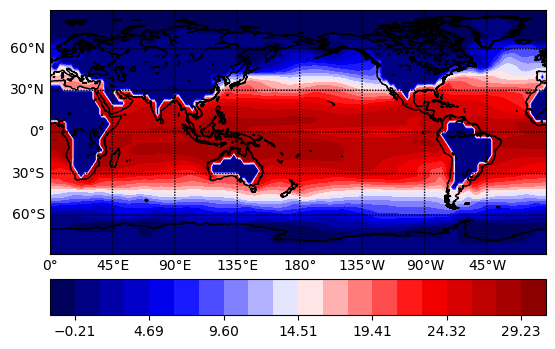

Shape of X_train: (25, 1427, 48, 144)


<Figure size 640x480 with 0 Axes>

In [1]:
!pip install netCDF4
import netCDF4 as nc
trY_SST_ds=nc.Dataset("drive/MyDrive/GISS-E2-1-H_historical_1850_2014.nc")
trY_SST=trY_SST_ds.variables['sst'][:,:,:,:,:].data
mask=1-trY_SST_ds.variables['sst'][0,0,0,:,:].mask
import numpy as np
from sklearn.utils import shuffle
import torch
import xarray as xr
from scipy.signal import detrend

trY_SST=trY_SST[:,21:-4,:,:]  #1871 - 2010
trY_SST=np.nan_to_num(trY_SST)

trY_SST_anom = trY_SST-np.expand_dims(trY_SST.mean(1),1)

trY_SST=trY_SST.reshape(trY_SST.shape[0],1680,48,144)#.reshape(16800,48,144)

trY_SST_train=trY_SST[:,:1428] #1871-1989
trY_SST_test=trY_SST[:,1428:].mean(axis=0) #1990-2010
X_train=trY_SST_train[:,:-1,:,:]#-np.expand_dims(trY_SST.mean(axis=1),1)
Y_train=trY_SST_train[:,1:,:,:]

X_test=trY_SST_test[:-1,:,:]
Y_test=trY_SST_test[1:,:,:]
lat_sst=trY_SST_ds.variables['lat'][:]
lon_sst=trY_SST_ds.variables['lon'][:]
!pip install basemap
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
def plot_map(lon,lat,data,file_name):
#     m = Basemap(projection='cyl', resolution='l',
#             llcrnrlat=np.min(lat), urcrnrlat=np.max(lat),
#             llcrnrlon=np.min(lon), urcrnrlon=np.max(lon), )

    m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=np.min(lat_sst), urcrnrlat=np.max(lat_sst),
            llcrnrlon=np.min(lon_sst), urcrnrlon=np.max(lon_sst), )
    #m.drawcoastlines()
    #plt.show()
    lons,lats= np.meshgrid(lon,lat)
    x,y = m(lons,lats)

    #m.drawcoastlines()
    levels = np.linspace(min(np.unique(data)),max(np.unique(data)),21)
    #levels = np.linspace(0.0,1.0,21)
    #levels=[-30,-20,-12,-9,-6,-2,-1,+1,+2,+6,+9,+12,+20,+30]
    temp = m.contourf(x,y,data,levels=levels,cmap='seismic')
    cb = m.colorbar(temp,"bottom", size="15%", pad="10%")
    m.drawcoastlines()
    m.drawparallels(np.arange(-90., 91., 30.), labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(0., 361., 45.), labels=[0, 0, 0, 1])
    #plt.title('sst')
    #cb.set_label('sst')

    plt.savefig(file_name)

    plt.show()
    plt.clf()

plot_map(lon_sst,lat_sst,X_train[0,0,:,:],'file.png')
print("Shape of X_train:", X_train.shape)

In [2]:
def EOF(Data, lat, lon):
    wgts   = np.cos(np.deg2rad(lat))
    wgts   = wgts.reshape(len(wgts), 1)
    #solver1 = Eof(np.array(ser_original[6]), weights=wgts)

    coslat = np.cos(np.deg2rad(lat))
    wgts = np.sqrt(coslat)[..., np.newaxis]
    solver =Eof(Data,weights=wgts)
    eof1=solver.eofs()

    pc=solver.pcs(pcscaling=1)
    varfrac=solver.varianceFraction()
    lambdas=solver.eigenvalues()


    parallels = np.arange(-90,90,20)
    meridians = np.arange(-180,180,40)

    fig=plt.figure(figsize=(10,16))

    m=Basemap(projection='cyl', llcrnrlon=min(lon), llcrnrlat=min(lat),
            urcrnrlon=max(lon), urcrnrlat=max(lat), resolution='l')
    x, y = m(*np.meshgrid(lon,lat))
    clevs = np.linspace(-0.1,0.1,12)

    cs = m.contourf(x,y,eof1[0,:,:].squeeze(),clevs,cmap=plt.cm.RdBu_r)
    m.drawcoastlines()
    m.fillcontinents(color='#000000',lake_color='#99ffff')
    m.drawparallels(parallels,labels=[1,0,0,0])
    m.drawmeridians(meridians,labels=[1,0,0,1])

    cb=m.colorbar(cs, 'bottom', size='5%',pad='10%')
    #cb.set_label('EOF', fontsize=10)
    plt.title('EOF1', fontsize=15)
    plt.show()
    return eof1[0]

In [3]:
!pip install eofs

In [4]:
from eofs.standard import Eof

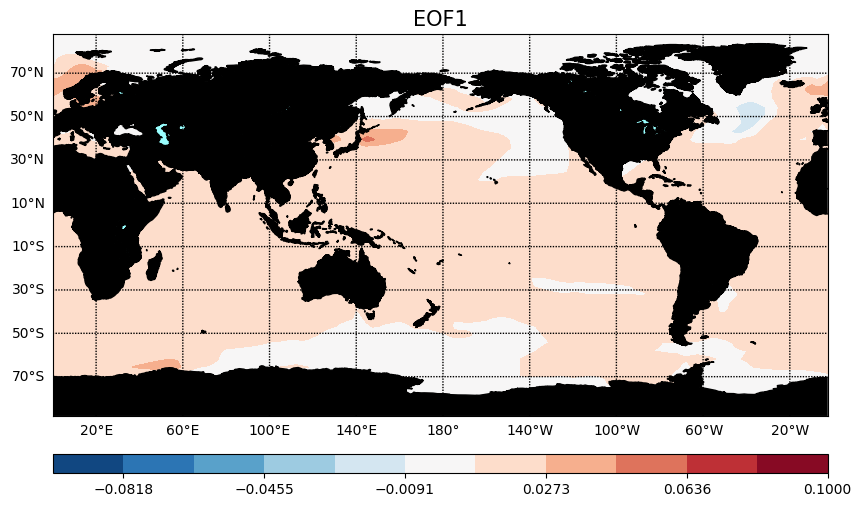

In [5]:
# Step 1: Extract surface level anomalies (level 0)
sst_anom_surface = trY_SST_anom[:, :, 0, :, :]  # shape: (25, 140, 48, 144)

# Step 2: Average across ensemble members
sst_anom_surface_mean = np.mean(sst_anom_surface, axis=0)  # shape: (140, 48, 144)

# Now call the EOF function
eof1_result = EOF(sst_anom_surface_mean, lat_sst, lon_sst)

Epoch 1/50
  Total Loss: 0.3595
  Recon Loss: 0.1114
  KL Loss: 789.5772 (weight: 0.00)
  State Loss: 2.4812
  Learning rate: 0.000500
Epoch 2/50
  Total Loss: 0.7040
  Recon Loss: 0.2230
  KL Loss: 4.6473 (weight: 0.05)
  State Loss: 2.4865
  Learning rate: 0.000500
Epoch 3/50
  Total Loss: 0.5640
  Recon Loss: 0.1771
  KL Loss: 1.3901 (weight: 0.10)
  State Loss: 2.4795
  Learning rate: 0.000500
Epoch 4/50
  Total Loss: 0.6251
  Recon Loss: 0.1967
  KL Loss: 1.2044 (weight: 0.15)
  State Loss: 2.4768
  Learning rate: 0.000500
Epoch 5/50
  Total Loss: 0.6800
  Recon Loss: 0.2194
  KL Loss: 1.0650 (weight: 0.20)
  State Loss: 2.4755
  Learning rate: 0.000250
Epoch 6/50
  Total Loss: 0.7233
  Recon Loss: 0.2372
  KL Loss: 0.9552 (weight: 0.25)
  State Loss: 2.4731
  Learning rate: 0.000250
Epoch 7/50
  Total Loss: 0.7728
  Recon Loss: 0.2613
  KL Loss: 0.8809 (weight: 0.30)
  State Loss: 2.4723
  Learning rate: 0.000250
Epoch 8/50
  Total Loss: 0.8146
  Recon Loss: 0.2871
  KL Loss: 0.8

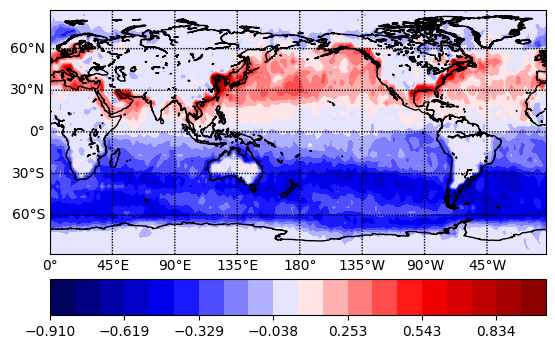


Transition Matrix (shape: 12x12):
[[0.05438017 0.4018181  0.05438017 0.05438017 0.05438017 0.05438017
  0.05438017 0.05438017 0.05438017 0.05438017 0.05438017 0.05438017]
 [0.05438017 0.05438017 0.4018181  0.05438017 0.05438017 0.05438017
  0.05438017 0.05438017 0.05438017 0.05438017 0.05438017 0.05438017]
 [0.05438017 0.05438017 0.05438017 0.4018181  0.05438017 0.05438017
  0.05438017 0.05438017 0.05438017 0.05438017 0.05438017 0.05438017]
 [0.05438017 0.05438017 0.05438017 0.05438017 0.40181816 0.05438017
  0.05438017 0.05438017 0.05438017 0.05438017 0.05438017 0.05438017]
 [0.05438017 0.05438017 0.05438017 0.05438017 0.05438017 0.40181816
  0.05438017 0.05438017 0.05438017 0.05438017 0.05438017 0.05438017]
 [0.05438017 0.05438017 0.05438017 0.05438017 0.05438017 0.05438017
  0.40181816 0.05438017 0.05438017 0.05438017 0.05438017 0.05438017]
 [0.05438017 0.05438017 0.05438017 0.05438017 0.05438017 0.05438017
  0.05438017 0.40181816 0.05438017 0.05438017 0.05438017 0.05438017]
 [0.05

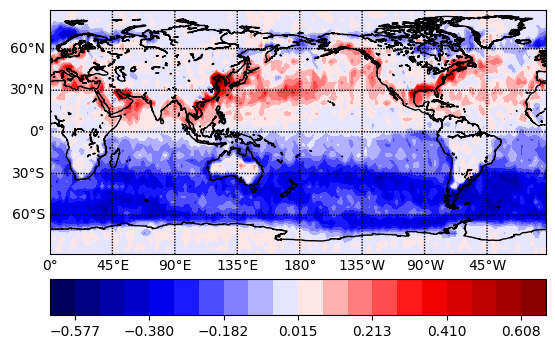

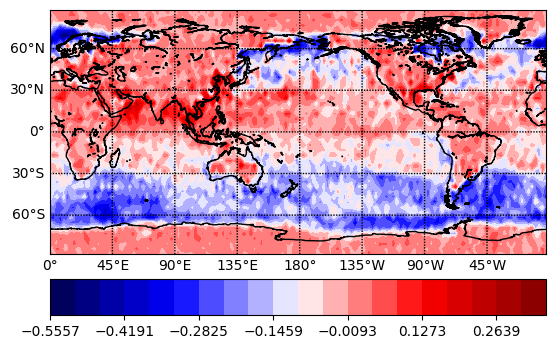

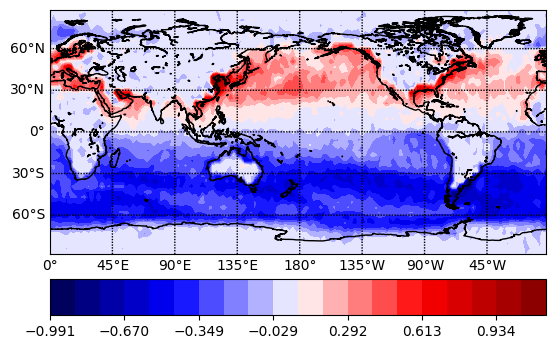

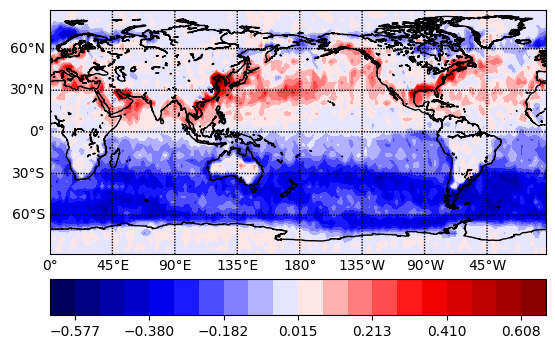

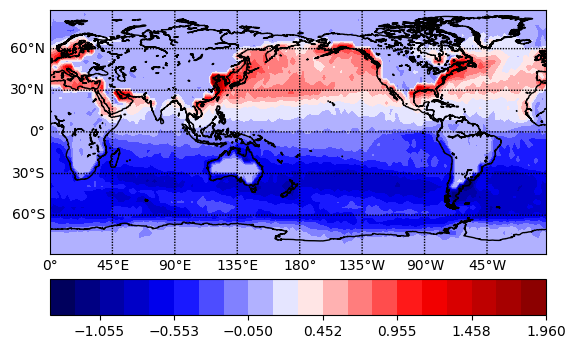

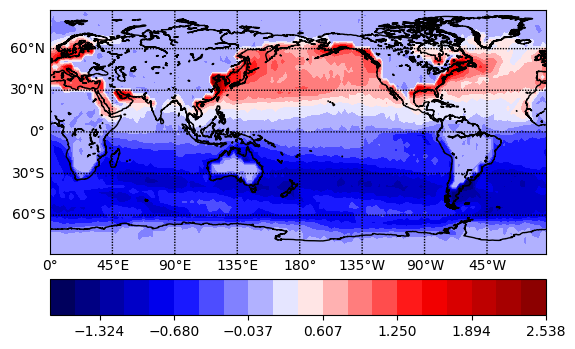

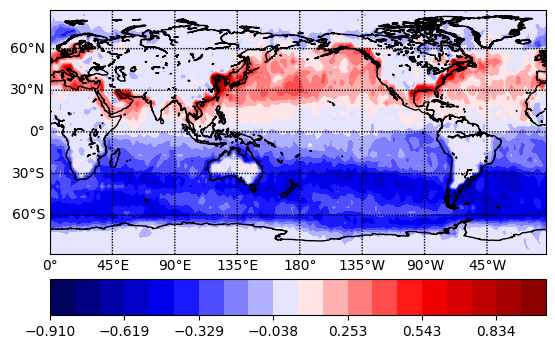

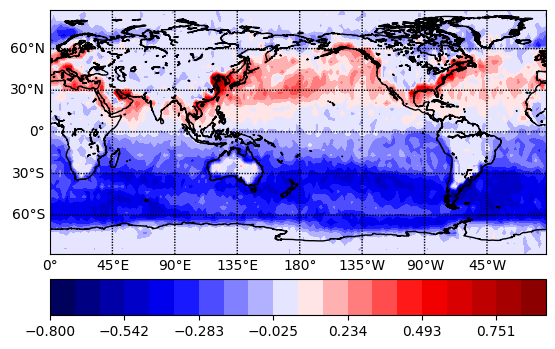

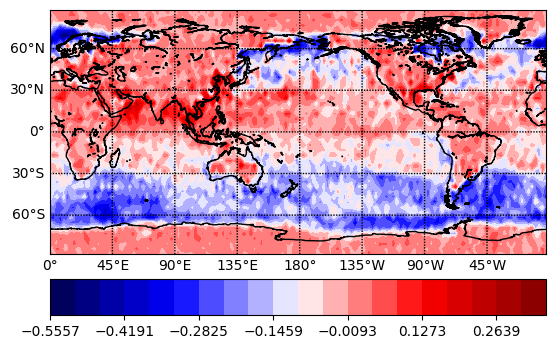

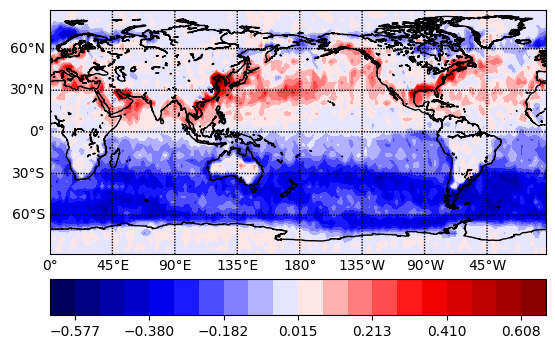


Test MSE: 260.5541


<Figure size 640x480 with 0 Axes>

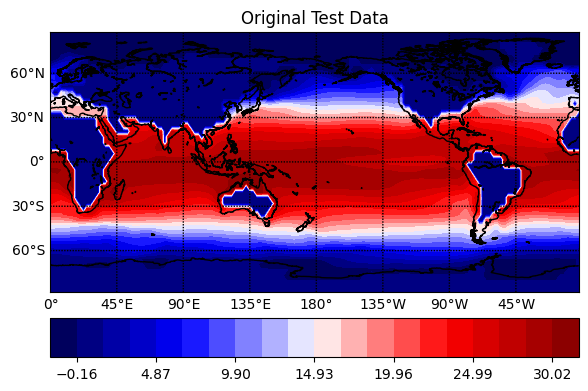

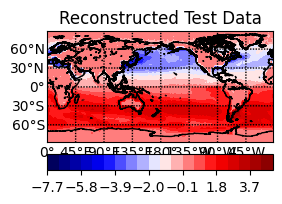

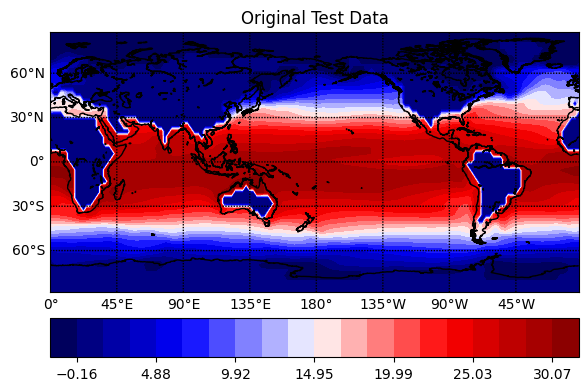

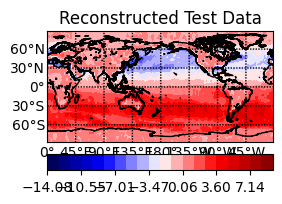

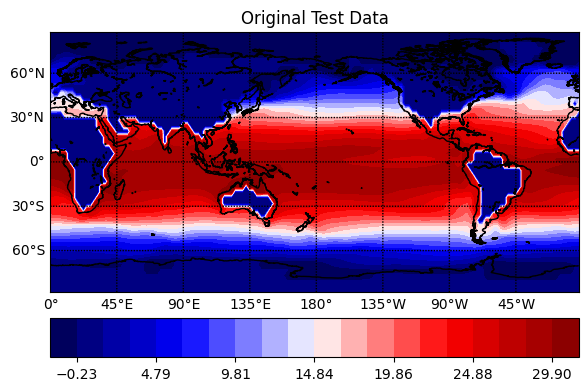

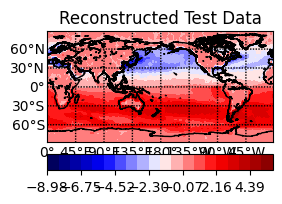

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Improved HMM-VAE Setup ---

latent_dim = 64  # Increased from 32
num_states = 12  # 12 months
seq_len = 120  # e.g. 10 years = 120 months

# ---- Preprocess anomaly data ----
trY_SST_anom = trY_SST - np.expand_dims(trY_SST.mean(1), 1)
trY_SST_anom = trY_SST_anom[:, :1428]  # 1871–1989
X = trY_SST_anom[:, :-1]  # input
Y = trY_SST_anom[:, 1:]   # output
X = X.reshape(-1, 48, 144)
X = torch.tensor(X, dtype=torch.float32).unsqueeze(1).to(device)  # (N, 1, H, W)

# Data normalization - important for stable training
X_mean = X.mean()
X_std = X.std()
X_norm = (X - X_mean) / X_std

train_loader = DataLoader(TensorDataset(X_norm), batch_size=32, shuffle=True)  # Smaller batch size

# ---- Improved Encoder with strided convolutions ----
class ImprovedEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            # First conv block - 48x144 -> 24x72
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),

            # Second conv block - 24x72 -> 12x36
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            # Third conv block - 12x36 -> 6x18
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            # Fourth conv block - 6x18 -> 3x9
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )

        # Much smaller fully connected layers (128 * 3 * 9 = 3456)
        self.fc_mu = nn.Linear(128 * 3 * 9, latent_dim)
        self.fc_logvar = nn.Linear(128 * 3 * 9, latent_dim)

    def forward(self, x):
        h = self.conv(x)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# ---- Improved Decoder with transposed convolutions ----
class ImprovedDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 128 * 3 * 9)

        self.deconv = nn.Sequential(
            # First deconv block - 3x9 -> 6x18
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            # Second deconv block - 6x18 -> 12x36
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            # Third deconv block - 12x36 -> 24x72
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),

            # Fourth deconv block - 24x72 -> 48x144
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, z):
        h = self.fc(z)
        h = h.view(-1, 128, 3, 9)
        return self.deconv(h)

# ---- Improved HMM Layer with better state representation ----
class ImprovedHMM(nn.Module):
    def __init__(self, latent_dim, num_states):
        super().__init__()
        # Initial transition matrix
        self.transitions = nn.Parameter(torch.zeros(num_states, num_states))

        # Create seasonal pattern with stronger next-month transitions
        for i in range(num_states):
            next_month = (i + 1) % num_states
            self.transitions.data[i, next_month] = 2.0  # Higher probability for next month transition

        # State embeddings with initialization
        self.state_embeddings = nn.Parameter(torch.randn(num_states, latent_dim) * 0.1)

        # Add a neural network to transform state embeddings
        self.state_transform = nn.Sequential(
            nn.Linear(latent_dim, latent_dim * 2),
            nn.LayerNorm(latent_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim * 2, latent_dim)
        )

    def forward(self, prev_state):
        probs = F.softmax(self.transitions[prev_state], dim=0)
        new_state = torch.multinomial(probs, 1).item()
        z = self.state_embeddings[new_state]
        z_transformed = self.state_transform(z)
        return z_transformed, new_state

    def transition_matrix(self):
        return F.softmax(self.transitions, dim=1).detach().cpu().numpy()

# ---- Improved VAE-HMM Model with stronger connection between components ----
class ImprovedHMMVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = ImprovedEncoder()
        self.decoder = ImprovedDecoder()
        self.hmm = ImprovedHMM(latent_dim, num_states)

        # State classifier to provide feedback from VAE to HMM
        self.state_classifier = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, num_states)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        state_logits = self.state_classifier(z)
        return x_recon, mu, logvar, state_logits

# Initialize model and optimizer
model = ImprovedHMMVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)  # Added weight decay

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# ---- Training with KL annealing ----
epochs = 50  # Increased from 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0
    total_state_loss = 0

    # KL annealing - gradually increase KL weight from 0 to 1
    kl_weight = min(1.0, epoch / 20)

    for x_batch, in train_loader:
        x_batch = x_batch.to(device)

        # Get month information for state classification (assuming sequential months)
        batch_size = x_batch.size(0)
        month_indices = torch.remainder(torch.arange(batch_size), num_states).to(device)

        # Forward pass
        recon, mu, logvar, state_logits = model(x_batch)

        # Reconstruction loss
        recon_loss = F.mse_loss(recon, x_batch)

        # KL divergence loss with annealing
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_size

        # State classification loss to align latent space with HMM states
        state_loss = F.cross_entropy(state_logits, month_indices)

        # Total loss with weighted components
        loss = recon_loss + kl_weight * kl_loss + 0.1 * state_loss

        # Optimization step
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Accumulate losses
        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()
        total_state_loss += state_loss.item()

    # Update learning rate based on loss
    avg_loss = total_loss / len(train_loader)
    scheduler.step(avg_loss)

    # Print detailed loss components
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Total Loss: {total_loss/len(train_loader):.4f}")
    print(f"  Recon Loss: {total_recon_loss/len(train_loader):.4f}")
    print(f"  KL Loss: {total_kl_loss/len(train_loader):.4f} (weight: {kl_weight:.2f})")
    print(f"  State Loss: {total_state_loss/len(train_loader):.4f}")
    print(f"  Learning rate: {optimizer.param_groups[0]['lr']:.6f}")

    # Validate and visualize occasionally
    if (epoch + 1) % 10 == 0:
        # Save model checkpoint
        torch.save(model.state_dict(), f"hmm_vae_epoch_{epoch+1}.pt")

        # Generate and visualize a sample
        model.eval()
        curr_state = np.random.randint(num_states)
        z, curr_state = model.hmm(curr_state)
        z = z.unsqueeze(0).to(device)
        x_gen = model.decoder(z).squeeze().cpu().detach().numpy()

        # Denormalize the generated sample
        x_gen = x_gen * X_std.cpu().numpy() + X_mean.cpu().numpy()

        # Plot sample
        if epoch + 1 == epochs:  # Only plot on last epoch to avoid too many plots
            plot_map(lon_sst, lat_sst, x_gen, f"epoch_{epoch+1}_sample.png")

# ---- Generation using HMM ----
model.eval()
state_seq = []
generated_seq = []

# Start with January (state 0)
curr_state = 0
for t in range(seq_len):
    z, curr_state = model.hmm(curr_state)
    # Denormalize the output
    x_gen = model.decoder(z.unsqueeze(0).to(device)).squeeze().cpu().detach().numpy()
    x_gen = x_gen * X_std.cpu().numpy() + X_mean.cpu().numpy()

    generated_seq.append(x_gen)
    state_seq.append(curr_state)

generated_seq = np.array(generated_seq)  # shape: (seq_len, 48, 144)

# ---- Transition Matrix ----
print("\nTransition Matrix (shape: 12x12):")
transition_mat = model.hmm.transition_matrix()
print(transition_mat)

# Calculate entropy of each row to check if transitions are too uniform
entropy = -np.sum(transition_mat * np.log(transition_mat + 1e-10), axis=1)
print("\nEntropy of transitions from each state:")
print(entropy)

print("\nState Sequence of Generated Frames:")
print(state_seq)

# Check if the state sequence follows a seasonal pattern
state_diff = [((state_seq[i+1] - state_seq[i]) % num_states) for i in range(len(state_seq)-1)]
print("\nState transitions (differences between consecutive states):")
print(state_diff)
print(f"Count of +1 transitions (ideal seasonal pattern): {state_diff.count(1)}/{len(state_diff)}")

# ---- Visualize Generated SST Anomalies ----
for i in range(0, seq_len, 12):  # plot 1 frame per year
    plot_map(lon_sst, lat_sst, generated_seq[i], f"gen_sst_{i}.png")

# Create a plot showing the pattern of states over time
plt.figure(figsize=(15, 5))
plt.plot(state_seq, marker='o')
plt.grid(True)
plt.title('State Sequence Over Time')
plt.xlabel('Time Step')
plt.ylabel('HMM State')
plt.yticks(range(num_states))
plt.savefig("state_sequence.png")
plt.close()

# Function to evaluate the model on test data
def evaluate_model(model, test_data):
    model.eval()
    test_tensor = torch.tensor(test_data, dtype=torch.float32).unsqueeze(1).to(device)
    test_tensor_norm = (test_tensor - X_mean) / X_std

    with torch.no_grad():
        recon, mu, logvar, _ = model(test_tensor_norm)
        recon = recon * X_std + X_mean
        test_mse = F.mse_loss(recon, test_tensor).item()

    return test_mse, recon.cpu().numpy()

# Evaluate on test data if available
try:
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)
    test_mse, test_recon = evaluate_model(model, X_test)
    print(f"\nTest MSE: {test_mse:.4f}")

    # Plot example of reconstruction on test data
    for i in range(min(3, len(X_test))):
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plt.title("Original Test Data")
        plot_map(lon_sst, lat_sst, X_test[i], f"test_original_{i}.png")

        plt.subplot(1, 2, 2)
        plt.title("Reconstructed Test Data")
        plot_map(lon_sst, lat_sst, test_recon[i, 0], f"test_recon_{i}.png")

        plt.close()
except:
    print("\nTest data not available for evaluation")

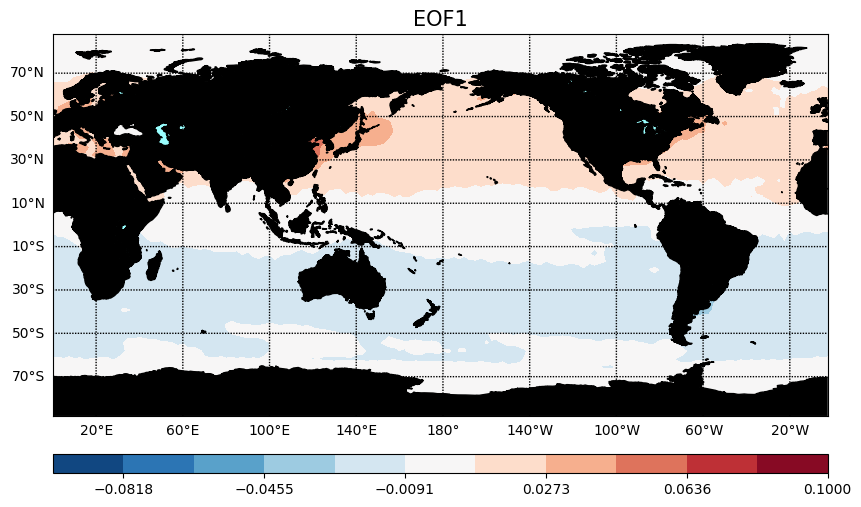

In [7]:
eof_generated = EOF(generated_seq, lat_sst, lon_sst)